In [10]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn import naive_bayes #import GaussianNB, MultinomialNB
from sklearn.linear_model import SGDClassifier # simulate the behavior of logistic regression using SGDClassifier(loss='log')
from sklearn.metrics import accuracy_score,balanced_accuracy_score,average_precision_score, classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from collections import Counter
from itertools import product

In [11]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [12]:
# Load the trained vectorizer
with open('tfidf_vectorizer_train_split_33k.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)
len(loaded_vectorizer.get_feature_names_out())

train_df = pd.read_csv('cfpb_train.csv')
test_df = pd.read_csv('cfpb_test.csv')
dev_df = pd.read_csv('cfpb_dev.csv')

C:\Users\JYM\AppData\Local\Temp/ipykernel_29416/2270551363.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('cfpb_train.csv')
C:\Users\JYM\AppData\Local\Temp/ipykernel_29416/2270551363.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dev_df = pd.read_csv('cfpb_dev.csv')


In [13]:
# some cleaning just ot make sure
train_df['Consumer complaint narrative'] = train_df['Consumer complaint narrative'].fillna('').astype(str)
test_df['Consumer complaint narrative'] = test_df['Consumer complaint narrative'].fillna('').astype(str)
dev_df['Consumer complaint narrative'] = dev_df['Consumer complaint narrative'].fillna('').astype(str)

train_df['debt_collection'] = (train_df['Product'] == 'Debt collection').astype(int)
test_df['debt_collection'] = (test_df['Product'] == 'Debt collection').astype(int)
dev_df['debt_collection'] = (dev_df['Product'] == 'Debt collection').astype(int)

In [14]:
print(train_df.shape)
print(test_df.shape)
print(dev_df.shape)

(825996, 24)
(110133, 24)
(165200, 24)


In [6]:
%%time
X_test = loaded_vectorizer.transform(test_df['Consumer complaint narrative'])
y_test = test_df['debt_collection']

X_dev = loaded_vectorizer.transform(dev_df['Consumer complaint narrative'])
y_dev = dev_df['debt_collection']

Wall time: 56.4 s


### Grid Search Model

In [19]:
# %%time
# # Define the parameters for exploration
# # First Run
# # param_grid = {
# #     'sample_size': [50000, 100000, 150000, 200000], # Example sizes, please adjust according to your needs
# #     'chi2_features': [10000, 20000, 30000], # Example feature numbers, please adjust according to your needs
# #     'clf__alpha': [1e-4, 1e-3, 1e-2],
# #     'clf__loss': ['hinge', 'log_loss', 'squared_hinge', ],
# #     'clf__penalty': ['elasticnet'],
# #     'clf__n_iter_no_change': [3],
# #     'clf__early_stopping': [True, False],
# #     'clf__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
# #     'clf__eta0': [0.01, 0.1]
# # }

# #Second Run
# # param_grid = {
# #     'sample_size': [200000, 300000, 400000, 500000], # Example sizes, please adjust according to your needs
# #     'chi2_features': [20000, 25000, 30000], # Example feature numbers, please adjust according to your needs
# #     'clf__alpha': [1e-4],
# #     'clf__loss': ['log_loss'], # 'squared_hinge' performs slightly better, but that is non-linear SVM
# #     'clf__penalty': ['elasticnet'],
# #     'clf__n_iter_no_change': [3],
# #     'clf__early_stopping': [False], # Does not show huge difference
# #     'clf__learning_rate': ['constant', 'adaptive'],
# #     'clf__eta0': [0.01]
# # }

# #Third Run
# param_grid = {
#     'sample_size': [200000, 250000, 300000, 400000], # Example sizes, please adjust according to your needs
#     'chi2_features': [20000, 22500, 25000], # Example feature numbers, please adjust according to your needs
#     'clf__alpha': [1e-4],
#     'clf__loss': ['log_loss'], # 'squared_hinge' performs slightly better, but that is non-linear SVM
#     'clf__penalty': ['elasticnet'],
#     'clf__n_iter_no_change': [3],
#     'clf__early_stopping': [False], # Does not show huge difference
#     'clf__learning_rate': ['constant'],
#     'clf__eta0': [0.01]
# }




# # Grid search
# # Here I will be defining a function to encapsulate the model training for different parameters
# # For example, the 'sample_size' and 'chi2_features' parameters are not a part of the SGDClassifier
# def grid_search_model(param_grid):
#     best_params = None
#     best_score = 0
#     prev_score = 0
    
#     for sample_size in param_grid['sample_size']:
#         for chi2_features in param_grid['chi2_features']:
#             # Sample and transform the train data
#             train_df_sample = train_df.sample(sample_size)
            
#             X_train = loaded_vectorizer.transform(train_df_sample['Consumer complaint narrative'])
#             y_train = train_df_sample['debt_collection']
            
#             selector = SelectKBest(chi2, k=chi2_features)
#             X_train = selector.fit_transform(X_train, y_train)
#             # Transform dev set with the same selector
#             X_dev_transformed = selector.transform(X_dev)
            
#             oversample = RandomOverSampler(sampling_strategy='minority')
#             X_train, y_train = oversample.fit_resample(X_train, y_train)
            
#             # Shuffle your data
#             X_train, y_train = shuffle(X_train, y_train)
            
#             # The product function is from Python's built-in itertools module. It computes the Cartesian product of input iterables, 
#             # which means it generates all possible combinations of the input iterables' elements.
#             for params in product(
#                 param_grid['clf__alpha'],
#                 param_grid['clf__loss'],
#                 param_grid['clf__penalty'],
#                 param_grid['clf__n_iter_no_change'],
#                 param_grid['clf__early_stopping'],
#                 param_grid['clf__learning_rate'],
#                 param_grid['clf__eta0']
#             ):
                
#                 # Apply the parameters
#                 alpha, loss, penalty, n_iter_no_change, early_stopping, learning_rate, eta0 = params
                
#                 clf = SGDClassifier(
#                     loss=loss, 
#                     penalty=penalty, 
#                     alpha=alpha, 
#                     n_iter_no_change=n_iter_no_change, 
#                     early_stopping=early_stopping, 
#                     learning_rate=learning_rate, 
#                     eta0=eta0, 
#                     random_state=42
#                 )
#                 # Train and score the model
#                 clf.fit(X_train, y_train)
#                 # F1 score: This is the harmonic mean of precision and recall, and it tries to balance these two values. 
#                 # It is especially useful if your classes are unevenly distributed.
#                 predicted = clf.predict(X_dev_transformed)
#                 score = f1_score(y_dev, predicted)
                
#                 if score > best_score:
#                     best_score = score
#                     best_params = {
#                         'sample_size': sample_size,
#                         'chi2_features': chi2_features,
#                         'clf__alpha': alpha,
#                         'clf__loss': loss,
#                         'clf__penalty': penalty,
#                         'clf__n_iter_no_change': n_iter_no_change,
#                         'clf__early_stopping': early_stopping,
#                         'clf__learning_rate': learning_rate,
#                         'clf__eta0': eta0
#                     }
#                     print(f"New best score:{score} using {best_params}")
# #                 else:
# #                     print(f"Currentscore:{score} using {best_params}")

#                 # If the improvement in the score is less than 0.01, stop the iterations
# #                 if abs(score - prev_score) < 0.01:
# #                     return best_params

#                 prev_score = score
                    
#     return best_params

# best_params = grid_search_model(param_grid)
# print(f'Best parameters: {best_params}')

New best score:0.7313343611364566 using {'sample_size': 200000, 'chi2_features': 20000, 'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet', 'clf__n_iter_no_change': 3, 'clf__early_stopping': False, 'clf__learning_rate': 'constant', 'clf__eta0': 0.01}
New best score:0.7315118626956084 using {'sample_size': 200000, 'chi2_features': 22500, 'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet', 'clf__n_iter_no_change': 3, 'clf__early_stopping': False, 'clf__learning_rate': 'constant', 'clf__eta0': 0.01}
New best score:0.7318706189293686 using {'sample_size': 250000, 'chi2_features': 25000, 'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet', 'clf__n_iter_no_change': 3, 'clf__early_stopping': False, 'clf__learning_rate': 'constant', 'clf__eta0': 0.01}
Best parameters: {'sample_size': 250000, 'chi2_features': 25000, 'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet', 'clf__n_iter_no_change': 3, 'c

### SGD Logistic Regression

In [7]:
%%time
sample_size =400000
chi2_features = 30000
alpha = 0.0001
loss = 'log_loss'
penalty=  'elasticnet'
n_iter_no_change = 3
early_stopping = False
learning_rate = 'constant'
eta0 =  0.01


train_df_sample = train_df.sample(sample_size)
            
X_train = loaded_vectorizer.transform(train_df_sample['Consumer complaint narrative'])
y_train = train_df_sample['debt_collection']

selector = SelectKBest(chi2, k=chi2_features)
X_train = selector.fit_transform(X_train, y_train)
# Transform dev set with the same selector
X_dev_transformed = selector.transform(X_dev)

oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)

clf = SGDClassifier(
                    loss=loss, 
                    penalty=penalty, 
                    alpha=alpha, 
                    n_iter_no_change=n_iter_no_change, 
                    early_stopping=early_stopping, 
                    learning_rate=learning_rate, 
                    eta0=eta0, 
                    random_state=42
                )
clf.fit(X_train, y_train)

Wall time: 1min 24s


SGDClassifier(eta0=0.01, learning_rate='constant', loss='log_loss',
              n_iter_no_change=3, penalty='elasticnet', random_state=42)

Train
accuracy_score 0.861085915198141
balanced_accuracy_score 0.8610859151981409
average_precision_score 0.8281165543378575
              precision    recall  f1-score   support

           0       0.82      0.92      0.87    329639
           1       0.91      0.80      0.85    329639

    accuracy                           0.86    659278
   macro avg       0.87      0.86      0.86    659278
weighted avg       0.87      0.86      0.86    659278

Prediction [(0, 368038), (1, 291240)]
Ground Truth [(0, 329639), (1, 329639)]


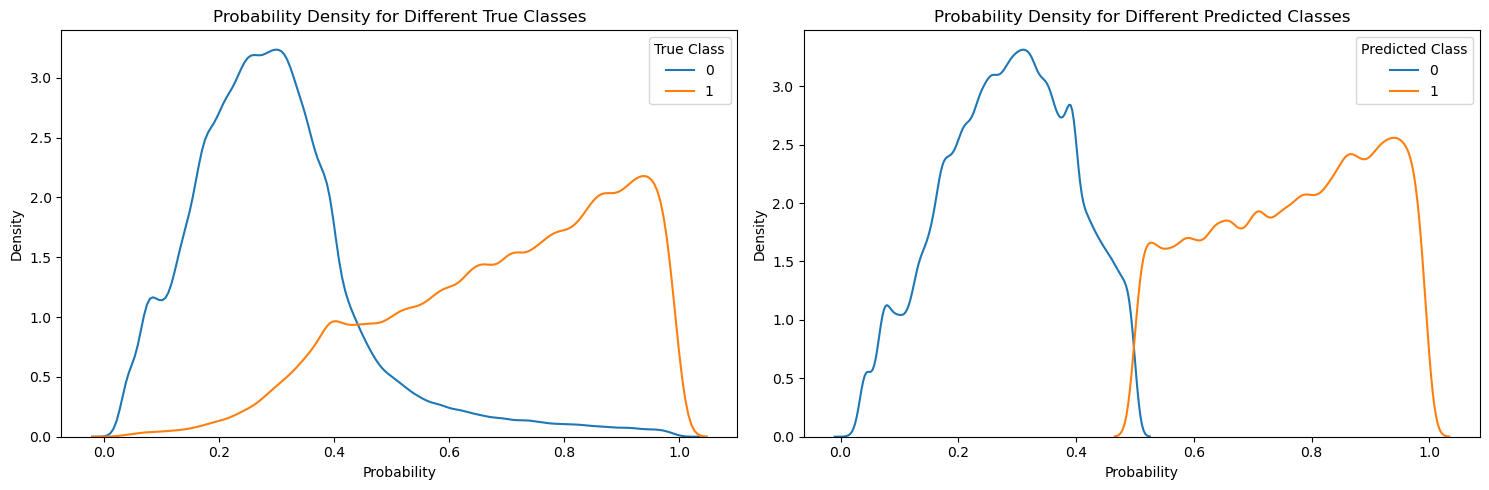

In [8]:
# get the results
y_pred = clf.predict(X_train.toarray())
y_pred_proba = clf.predict_proba(X_train.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train, y_pred))
print("average_precision_score",average_precision_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_train)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_train

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()

Train
accuracy_score 0.8980326876513317
balanced_accuracy_score 0.8575689964461513
average_precision_score 0.5775003605434884
              precision    recall  f1-score   support

           0       0.95      0.92      0.94    136036
           1       0.68      0.80      0.73     29164

    accuracy                           0.90    165200
   macro avg       0.82      0.86      0.84    165200
weighted avg       0.91      0.90      0.90    165200

Prediction [(0, 131147), (1, 34053)]
Ground Truth [(0, 136036), (1, 29164)]


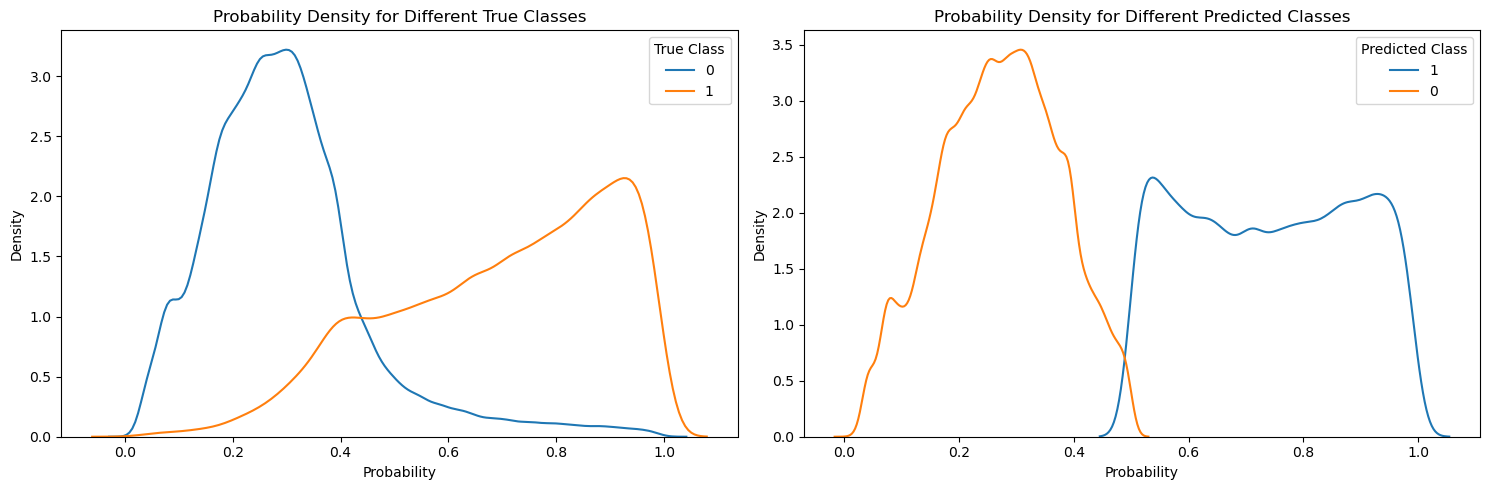

In [9]:
X_dev = selector.transform(X_dev)

# get the results
y_pred = clf.predict(X_dev.toarray())
y_pred_proba = clf.predict_proba(X_dev.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_dev

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()

Logistic Regression - Parameter Combinations that will Yield Similar Good Results

New best score:0.7289783920697958 using {'sample_size': 200000, 'chi2_features': 20000, 'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet', 'clf__n_iter_no_change': 3, 'clf__early_stopping': False, 'clf__learning_rate': 'constant', 'clf__eta0': 0.01}

New best score:0.7297195439841714 using {'sample_size': 200000, 'chi2_features': 20000, 'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet', 'clf__n_iter_no_change': 3, 'clf__early_stopping': False, 'clf__learning_rate': 'adaptive', 'clf__eta0': 0.01}

New best score:0.7303450115317633 using {'sample_size': 200000, 'chi2_features': 25000, 'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet', 'clf__n_iter_no_change': 3, 'clf__early_stopping': False, 'clf__learning_rate': 'constant', 'clf__eta0': 0.01}

New best score:0.7313343611364566 using {'sample_size': 200000, 'chi2_features': 20000, 'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet', 'clf__n_iter_no_change': 3, 'clf__early_stopping': False, 'clf__learning_rate': 'constant', 'clf__eta0': 0.01}

New best score:0.7313543423769961 using {'sample_size': 200000, 'chi2_features': 25000, 'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet', 'clf__n_iter_no_change': 3, 'clf__early_stopping': False, 'clf__learning_rate': 'adaptive', 'clf__eta0': 0.01}

New best score:0.7315118626956084 using {'sample_size': 200000, 'chi2_features': 22500, 'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet', 'clf__n_iter_no_change': 3, 'clf__early_stopping': False, 'clf__learning_rate': 'constant', 'clf__eta0': 0.01}

New best score:0.7317219399829604 using {'sample_size': 300000, 'chi2_features': 20000, 'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet', 'clf__n_iter_no_change': 3, 'clf__early_stopping': False, 'clf__learning_rate': 'constant', 'clf__eta0': 0.01}

New best score:0.7318706189293686 using {'sample_size': 250000, 'chi2_features': 25000, 'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet', 'clf__n_iter_no_change': 3, 'clf__early_stopping': False, 'clf__learning_rate': 'constant', 'clf__eta0': 0.01}

New best score:0.7322716583279407 using {'sample_size': 300000, 'chi2_features': 25000, 'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet', 'clf__n_iter_no_change': 3, 'clf__early_stopping': False, 'clf__learning_rate': 'constant', 'clf__eta0': 0.01}

New best score:0.7324859872108629 using {'sample_size': 400000, 'chi2_features': 30000, 'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__penalty': 'elasticnet', 'clf__n_iter_no_change': 3, 'clf__early_stopping': False, 'clf__learning_rate': 'constant', 'clf__eta0': 0.01}


It requires 200,000 samples and about 22500 features to yield acceptable results.

### 5-Fold CV

In [ ]:
cfpb_df = pd.read_csv('clean_narr_tmp.csv')